In [123]:
import os

import cv2
import numpy as np

# Define the new label groups based on original labels
label_groups = {
    0: list(range(0, 2)),  # Labels 0-1 will be consolidated into new label 0
    1: list(range(2, 8)),  # Labels 2-7 will be consolidated into new label 1
    2: list(range(8, 14))  # Labels 8-13 will be consolidated into new label 2
}

# Reverse mapping for convenience: original label to new label
original_to_new_label = {original: new for new, originals in label_groups.items() for original in originals}

def calculate_iou(mask1, mask2):
    '''Calculates Intersection over Union (IoU) for two binary masks'''
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def are_duplicates_based_on_overlap(mask1, mask2, threshold=0.95):
    '''Calculates the mutual overlap for two binary masks'''
    intersection = np.logical_and(mask1, mask2)
    overlap_area_1 = np.sum(intersection) / np.sum(mask1)
    overlap_area_2 = np.sum(intersection) / np.sum(mask2)
    return overlap_area_1 >= threshold and overlap_area_2 >= threshold

def parse_line(line):
    '''Parses a line and returns the original label and coordinates'''
    parts = line.split()
    original_label = int(parts[0])
    coordinates = np.array([float(coord) for coord in parts[1:]]).reshape(-1, 2)
    return original_label, coordinates

def create_mask(coordinates, image_dims):
    # Scale the normalized coordinates to the image dimensions
    scaled_coords = coordinates * np.array(image_dims)
    # Ensure the coordinates are integers, as required by cv2.fillPoly
    scaled_coords = np.round(scaled_coords).astype(np.int32)
    # Create an empty black image
    mask = np.zeros(image_dims, dtype=np.uint8)
    # Fill the polygon with white
    cv2.fillPoly(mask, [scaled_coords], color=1)
    return mask

# Read mask lines from the input file
input_directory_path = '/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/dataset_worked/train/labels'
for file in os.listdir(input_directory_path):
    if not file.endswith('.txt'):
        continue
    input_file_path = f'{input_directory_path}/{file}'
    with open(input_file_path, 'r') as f:
        mask_lines = f.readlines()

    # Calculate IoUs between all pairs of masks
    threshold = 0.95  # Threshold for considering masks as duplicates
    unique_mask_lines = []
    image_dims = (3840, 2160)  # Dimensions of the 4K image

    for line_i in mask_lines:
        original_label_i, coords_i = parse_line(line_i)
        new_label_i = original_to_new_label.get(original_label_i)
        mask_i = create_mask(coords_i, image_dims)
        is_duplicate = False
        for line_j in unique_mask_lines:
            new_label_j, coords_j = parse_line(line_j)
            if new_label_j == new_label_i:  # Compare only within the same new label group
                mask_j = create_mask(coords_j, image_dims)
                if are_duplicates_based_on_overlap(mask_i, mask_j, threshold=threshold):
                    is_duplicate = True
                    break
        if not is_duplicate:
            mask_area = np.sum(mask_i)
            if mask_area < 10000:
                unique_mask_lines.append(f"{new_label_i} {' '.join(map(str, coords_i.flatten()))}\n")

    # Write the consolidated mask data with new labels to the output file
    output_file_path = f'/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/dataset_worked/train/labels_filtered/{file}'
    with open(output_file_path, 'w') as f:
        # print(output_file_path)
        for line in unique_mask_lines:
            # print(line)
            f.write(line)

classes ['car', 'truck', 'license plate'] images {'3-00000.jpg': array([[[175, 166, 162],
        [175, 166, 162],
        [175, 166, 162],
        ...,
        [155, 152, 144],
        [155, 152, 144],
        [155, 152, 144]],

       [[175, 166, 162],
        [175, 166, 162],
        [175, 166, 162],
        ...,
        [153, 150, 142],
        [153, 150, 142],
        [153, 150, 142]],

       [[175, 166, 162],
        [175, 166, 162],
        [175, 166, 162],
        ...,
        [153, 150, 142],
        [153, 150, 142],
        [153, 150, 142]],

       ...,

       [[161, 163, 157],
        [181, 183, 177],
        [191, 193, 187],
        ...,
        [ 47,  48,  46],
        [ 47,  48,  46],
        [ 46,  47,  45]],

       [[180, 182, 176],
        [187, 189, 183],
        [189, 191, 185],
        ...,
        [ 45,  46,  44],
        [ 44,  45,  43],
        [ 44,  45,  43]],

       [[194, 196, 190],
        [187, 189, 183],
        [182, 184, 178],
        ...,
        [

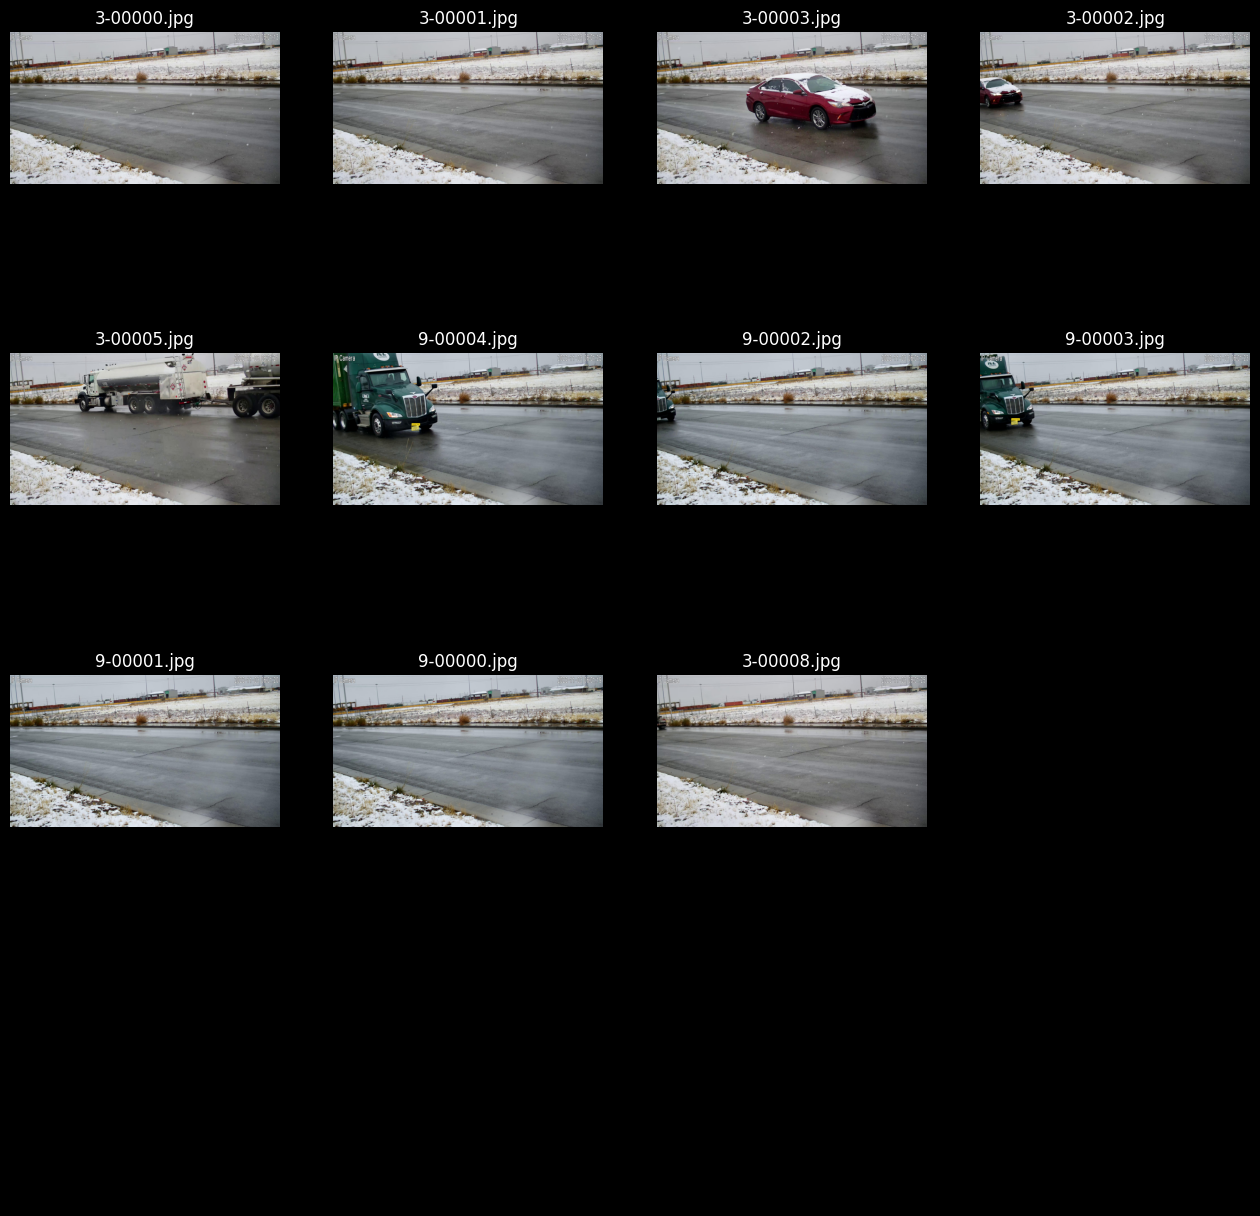

In [125]:
import supervision as sv
import os
HOME = os.getcwd()
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset_worked/train/labels_filtered"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset_worked/train/images"
DATA_YAML_PATH = f"{HOME}/dataset_worked/data_consolidated.yaml"
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

# TODO: Programatically edit the labels in the annotations files to consolidate the labels. (0-1 = 0: car), (2-7 = 1: truck), (8-13 = 2: license plate)

dataset = sv.DetectionDataset.from_yolo(
        images_directory_path=IMAGES_DIRECTORY_PATH,
        annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
        data_yaml_path=DATA_YAML_PATH)

len(dataset)
from annotate_images import process_images_in_parallel, plot_images_grid

SUPERIMPOSED_ANNOTATIONS_DIRECTORY_PATH = f"/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/dataset_worked/superimposed_annotations_test"

# Assuming 'dataset' is already defined and loaded in your notebook
images = process_images_in_parallel(dataset, SUPERIMPOSED_ANNOTATIONS_DIRECTORY_PATH)
plot_images_grid(images, list(dataset.images.keys()), SAMPLE_GRID_SIZE, SAMPLE_PLOT_SIZE)
